### `Importing all necessary modules`

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2

### `Creating a dataset class for images`

In [2]:
class FluxDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, transforms=None):
        self.data = df
        self.img_dir = img_dir
        self.transforms = transforms
    
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, index):
        # Reading the image and label
        image = cv2.imread(self.img_dir + self.data.iloc[index, 0], cv2.IMREAD_GRAYSCALE)
        label = torch.tensor(self.data.iloc[index, 1])

        # Cropping unnesessary parts of the image
        image = image[228:855,64:1856]
        
        # If any transformations are needed
        if self.transforms:
            # Then apply them
            image = Image.fromarray(image)
            image = self.transforms(image)
            image = F.adjust_sharpness(image, 4.5)              
        return (image, label) 

### `This code block can be used to divide images from the specified directory on train and test one`
    NB: it reads 10 files so it is recommended to have >10 images per each class and name them in the way:
     "[class_number][class_name][in_class_image_number].png"

In [3]:
# import shutil

# png_dir = './dataset/'
 
# get_files = os.listdir(png_dir)
# get_files.pop()
# get_files.pop()

# it = 0
# while(10*it < len(get_files)):
#     choice = np.random.choice(range(0, 10), 3, replace=False)
#     for num in range(0, 10):
#         if(num in choice):
#             shutil.move(png_dir + get_files[10*it + num], test_dir)
#         else:
#             shutil.move(png_dir + get_files[10*it + num], train_dir)
#     it += 1

### `Setting pathes to train and test directories`

In [3]:
train_dir = "./dataset/train/"
test_dir = "./dataset/test/"

### `Reading images and creating datasets and dataloaders`

In [4]:
import re

# Getting all names of the files in the directories
train_image_names = os.listdir(train_dir)
test_image_names = os.listdir(test_dir)

# Creating the dataframes to store the data about the image names and labels
train_df, test_df = pd.DataFrame(columns=['i_name', 'label']), pd.DataFrame(columns=['i_name', 'label'])

# Iterate over all names and add each of them in appropriate dataframe
for image_name in train_image_names:
    num = int(re.search('\d+', image_name).group()) - 1
    row = np.array([image_name, num]).reshape(-1, 2)
    train_df = pd.concat([train_df, pd.DataFrame(row, columns=['i_name', 'label'])], ignore_index=True)

for image_name in test_image_names:
    num = int(re.search('\d+', image_name).group()) - 1
    row = np.array([image_name, num]).reshape(-1, 2)
    test_df = pd.concat([test_df, pd.DataFrame(row, columns=['i_name', 'label'])], ignore_index=True)

# Some data conversions
train_df['label'] = train_df['label'].astype('int64')
test_df['label'] = test_df['label'].astype('int64')

# Some transformations over the images for improving the quality of the predictions of the CNN
train_transforms = T.Compose([
    T.Resize(size=(200, 200)),
    T.ToTensor(),
])

test_transforms = T.Compose([
    T.Resize(size=(200, 200)),
    T.ToTensor(),
])

train_batch_size, test_batch_size = 16, 16

train_dataset = FluxDataset(train_df, train_dir, train_transforms)
test_dataset = FluxDataset(test_df, test_dir, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

### `Print random sample of images from the test loader`

16 8 22 15 

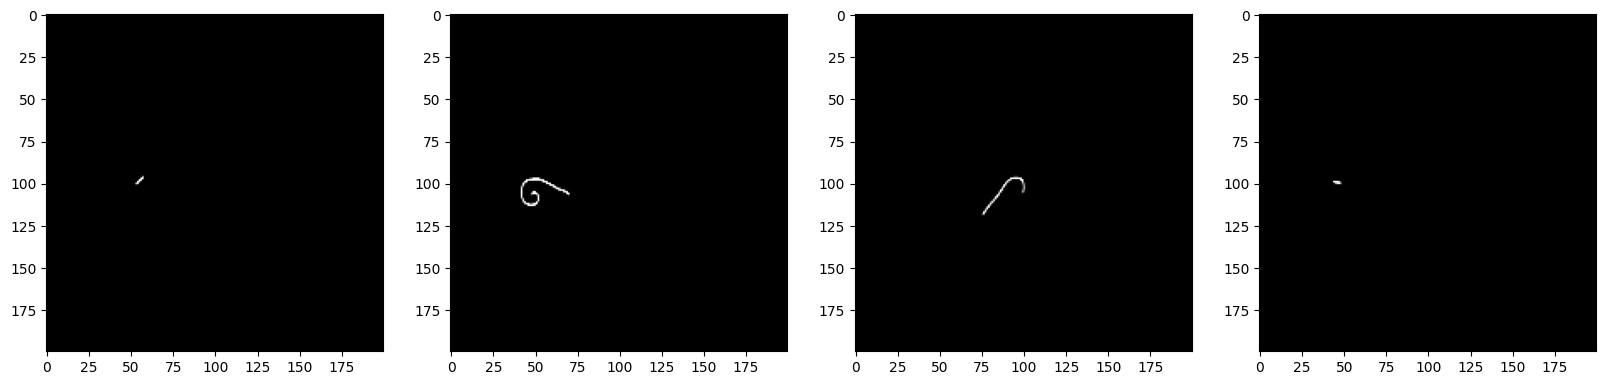

In [5]:
images, _ = next(iter(test_loader))

fig = plt.figure(figsize=(20, 20))
img = None

for i in range(4):
    if images[i].shape[0] == 1:
        img = images[i][0, :, :]
    fig.add_subplot(1, 4, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    print(_[i].item(), end=" ")

### `Creating functions for training and validating the model`

In [6]:
from tqdm import tqdm
import torch.nn as nn

def train(model, device, train_loader, criterion, score, optimizer, epoch):
    epoch_loss = 0
    epoch_f1_score = 0 
    iteration = 0
    
    model.train()

    # We will iterate over the train dataloader and in addition show the training progress
    bar = tqdm(train_loader)
    for data, target in bar:
        # Transfer data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data)

        loss = criterion(output, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increase the counter of epochs and print the average loss over the epoch 
        epoch_loss += loss.item()
        epoch_f1_score += score(output, target).item()
        iteration += 1
        bar.set_postfix({
            "Epoch": epoch,
            "Avg. loss": format(epoch_loss/iteration, '.6f'),
            "F1 score": format(epoch_f1_score/iteration, '.6f')
        })

    return epoch_loss/iteration

# This is the function for testing our model
def test(model, device, test_loader, criterion, score):
    test_loss = 0
    test_f1_score = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        # Here we will iterate over the test dataloader
        for data, target in test_loader:
            # Transfer the data and label on the device
            data, target = data.to(device), target.to(device)
            # Get the prediction
            output = model(data)
            # Sum up batch loss
            test_loss += criterion(output, target).item()
            test_f1_score += score(output, target).item()
            # Get the index of the max log-probability 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    # Calculate accuracy and return it with the test loss
    acc = 100. * correct / len(test_loader.dataset)
    # print("F1 score: ", format(test_f1_score/len(test_loader.dataset), '.6f'))
    return test_loss, acc

### `Setting the device to train and validate the model on`

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Device: {device}')

Device: cuda


### `Choosing the model architecture`

In [18]:
from model_arch import ResNet, Alex_like

# model = ResNet(num_classes=26).to(device)
model = Alex_like(num_classes=26).to(device)
# print(model)

### `Starting the training process`

In [19]:
import torch.optim as optim
import copy
from torchmetrics.classification import F1Score

# Here some hyperparameters
epochs = 20
lr = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
score = F1Score(task="multiclass", num_classes=26).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# And here is where the training process starts 
for epoch in range(1, epochs + 1):
    # Train the model
    train_loss = train(model, device, train_loader, criterion, score, optimizer, epoch)
    # Change the learning rate depending on the training loss got
    scheduler.step(train_loss)

    # Evaluate the test loss and accuracy
    test_loss, test_acc = test(model, device, test_loader, criterion, score)

    # Deep copy the model if its score is better than the current best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print("Best acc:", best_acc)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:09<00:00,  2.38it/s, Epoch=1, Avg. loss=3.155434, F1 score=0.071558]


Best acc: 3.8461538461538463


100%|██████████| 23/23 [00:09<00:00,  2.37it/s, Epoch=2, Avg. loss=2.583529, F1 score=0.180254]


Best acc: 12.179487179487179


100%|██████████| 23/23 [00:09<00:00,  2.43it/s, Epoch=3, Avg. loss=2.116543, F1 score=0.299819]


Best acc: 45.51282051282051


100%|██████████| 23/23 [00:09<00:00,  2.39it/s, Epoch=5, Avg. loss=1.549450, F1 score=0.425725]


Best acc: 58.333333333333336


100%|██████████| 23/23 [00:10<00:00,  2.29it/s, Epoch=7, Avg. loss=1.010625, F1 score=0.629529]


Best acc: 66.02564102564102


100%|██████████| 23/23 [00:09<00:00,  2.40it/s, Epoch=8, Avg. loss=0.826849, F1 score=0.683877]


Best acc: 72.43589743589743


100%|██████████| 23/23 [00:09<00:00,  2.40it/s, Epoch=9, Avg. loss=0.720991, F1 score=0.728261]


Best acc: 78.84615384615384


100%|██████████| 23/23 [00:10<00:00,  2.21it/s, Epoch=10, Avg. loss=0.575912, F1 score=0.822464]


Best acc: 79.48717948717949


100%|██████████| 23/23 [00:10<00:00,  2.26it/s, Epoch=11, Avg. loss=0.510589, F1 score=0.817935]


Best acc: 87.17948717948718


100%|██████████| 23/23 [00:10<00:00,  2.21it/s, Epoch=13, Avg. loss=0.225894, F1 score=0.934783]


Best acc: 88.46153846153847


100%|██████████| 23/23 [00:10<00:00,  2.28it/s, Epoch=14, Avg. loss=0.203226, F1 score=0.949275]


Best acc: 91.02564102564102


100%|██████████| 23/23 [00:09<00:00,  2.39it/s, Epoch=18, Avg. loss=0.046445, F1 score=0.997283]


Best acc: 92.3076923076923


100%|██████████| 23/23 [00:09<00:00,  2.40it/s, Epoch=19, Avg. loss=0.044040, F1 score=0.994565]


Best acc: 96.15384615384616


100%|██████████| 23/23 [00:09<00:00,  2.37it/s, Epoch=20, Avg. loss=0.028145, F1 score=1.000000]


### `Saving best model's state`

In [ ]:
# Creating "/runs" directory for storing states of the models that are trained
path = "runs"
if not os.path.exists(path):
    os.makedirs(path)
  
model.load_state_dict(best_model_wts)    
torch.save(model.state_dict(), "./runs/Alex_Like.pt")

<table>
<tr><td>

| Class_num   |      Class_name      |
|-------------|----------------------|
|      1      |         rtro         |
|      2      |         ruro         |
|      3      |         rfro         |
|      4      |         rtrs         |
|      5      |         rurs         |
|      6      |         rfrs         |
|      7      |         ltro         |
|      8      |         luro         |
|      9      |         lfro         |
|      10     |         ltrs         |
|      11     |         lurs         |
|      12     |         lfrs         |

</td><td>

| Class_num   |      Class_name      |
|-------------|----------------------|
|      13      |         rts         |
|      14      |         rus         |
|      15      |         rfs         |
|      16      |         lts         |
|      17      |         lus         |
|      18      |         lfs         |
|      19      |         rta         |
|      20      |         rua         |
|      21      |         rfa         |
|      22      |         lta         |
|      23      |         lua         |
|      24      |         lfa         |

</td><td>

| Class_num   |      Class_name      |
|-------------|----------------------|
|      25     |         ct          |
|      26     |         cct         |

</td></tr> 
</table>

### `Loading the state for the model and predicting classes for the images from "dataset/show" directory`

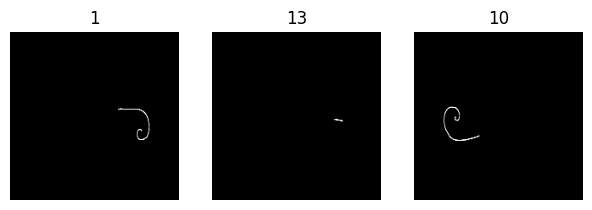

In [22]:
model = Alex_like(num_classes=26).to(device)
# model = ResNet(num_classes=26).to(device)

model.load_state_dict(torch.load('./runs/Alex_Like.pt'))
# model.load_state_dict(torch.load('./runs/ResNet34.pt'))

show_dir = 'dataset/show/'
show_images = os.listdir(show_dir)

image_num = 1
fig = plt.figure(figsize=(10, 10))

for image_name in show_images:
    # Preprocessign the image
    image = cv2.imread(show_dir + image_name, cv2.IMREAD_GRAYSCALE)
    image = image[228:855, 64:1856]
    
    image = Image.fromarray(image)
    image = test_transforms(image)
    image = F.adjust_sharpness(image, 4.5)

    image = image.numpy()[np.newaxis, :, :, :]

    image = torch.tensor(image).to(device)
    
    # Making a prediction
    model.eval()
    with torch.no_grad():
        pred_class = model(image).argmax(dim=1, keepdim=True) + 1

    # Adding the image with predicted class in a subplot
    fig.add_subplot(len(show_images) // 4 + 1, 4, image_num)
    plt.imshow(image.cpu().numpy()[0, 0, :, :], cmap="gray")
    plt.axis('off')
    plt.title(pred_class.item())
    
    image_num += 1

# Showing all the images with predicted classes
plt.show()

# Cleaning the memory
if(use_cuda):
    torch.cuda.empty_cache()
del model